## Problem Statement

How does geography correlate with other data attributes, such as provider density, provider specialties, or costs?

## Import Libraries

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Importing and Cleaning Dataset

### Medicare Provider Dataset

This dataset contains the overall drug utilization (claims, 30-day standardized fill counts and day’s supply), drug costs, and beneficiary counts organized by National Provider Identifier. Drug utilization, drug costs, and beneficiary counts are also included for each of the following sub group classifications:
* Beneficiaries age 65 and older
* Brand drugs, generic drugs, and other drugs
* Medicare Advantage Prescription Drug (MAPD) and stand-alone Prescription Drug Plans (PDP)
* Low-income subsidy (LIS) and no low-income subsidy (nonLIS)
* Opioids, long-actingopioids, antibiotics, and antipsychoticsin the elderly

In [64]:
provider = pd.read_csv('PartD_Prescriber_PUF_NPI_17.txt', sep='\t')
provider.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,beneficiary_male_count,beneficiary_race_white_count,beneficiary_race_black_count,beneficiary_race_asian_pi_count,beneficiary_race_hispanic_count,beneficiary_race_nat_ind_count,beneficiary_race_other_count,beneficiary_nondual_count,beneficiary_dual_count,beneficiary_average_risk_score
0,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,92.0,220.0,14.0,0.0,0.0,0.0,0.0,143.0,91.0,2.1685
1,1003000142,KHALIL,RASHID,NaN,M.D.,M,I,4126 N HOLLAND SYLVANIA RD,SUITE 220,TOLEDO,...,92.0,195.0,58.0,NaN,NaN,0.0,NaN,143.0,133.0,1.8029
2,1003000167,ESCOBAR,JULIO,E,DDS,M,I,5 PINE CONE RD,NaN,DAYTON,...,17.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,1.0598
3,1003000175,REYES-VASQUEZ,BELINDA,NaN,D.D.S.,F,I,322 N AZUSA AVE STE 202,NaN,LA PUENTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1003000282,BLAKEMORE,ROSIE,K,FNP,F,I,TENNESSEE PRISON FOR WOMEN,3881 STEWARTS LANE,NASHVILLE,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,4.5148


In [42]:
non_us = provider[provider.nppes_provider_country != 'US']
print(len(non_us))
non_us[['nppes_provider_zip4', 'nppes_provider_city', 'nppes_provider_state', 'nppes_provider_country']].head()

166


,nppes_provider_zip4,nppes_provider_city,nppes_provider_state,nppes_provider_country
3675,NaN,WATERLOO,ZZ,CA
12358,3.0,SHANGHAI,ZZ,CN
19753,NaN,FPO AE,ZZ,ES
22320,NaN,APO,ZZ,DE
24980,NaN,LANCASTER,ZZ,AA


There seems to be 166 non-US providers included in this dataset. However, for this analysis I will focus on the overall metrics for beneficiaries and their demographics only for providers in the US. 

In [65]:
# Checking the data
us_provider = provider[provider.nppes_provider_country == 'US'][['npi', 'nppes_provider_gender',
       'nppes_entity_code', 'nppes_provider_zip5', 'nppes_provider_city','nppes_provider_state', 'specialty_description', 'total_claim_count',
       'total_30_day_fill_count', 'total_drug_cost', 'total_day_supply','bene_count', 'average_age_of_beneficiaries', 
       'beneficiary_age_less_65_count', 'beneficiary_age_65_74_count', 'beneficiary_age_75_84_count',
       'beneficiary_age_greater_84_count', 'beneficiary_female_count', 'beneficiary_male_count', 'beneficiary_race_white_count',
       'beneficiary_race_black_count', 'beneficiary_race_asian_pi_count','beneficiary_race_hispanic_count', 'beneficiary_race_nat_ind_count',
       'beneficiary_race_other_count', 'beneficiary_nondual_count', 'beneficiary_dual_count', 'beneficiary_average_risk_score']]
del(provider)
us_provider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162732 entries, 0 to 1162897
Data columns (total 28 columns):
npi                                 1162732 non-null int64
nppes_provider_gender               1162729 non-null object
nppes_entity_code                   1162732 non-null object
nppes_provider_zip5                 1162731 non-null float64
nppes_provider_city                 1162732 non-null object
nppes_provider_state                1162732 non-null object
specialty_description               1162732 non-null object
total_claim_count                   1162732 non-null int64
total_30_day_fill_count             1162732 non-null float64
total_drug_cost                     1162732 non-null float64
total_day_supply                    1162732 non-null int64
bene_count                          1030928 non-null float64
average_age_of_beneficiaries        1030928 non-null float64
beneficiary_age_less_65_count       645242 non-null float64
beneficiary_age_65_74_count         540060 no

### Filling in Missing Values

1 of the provider does not have zip code information; however, I am keeping my analysis at the state level so this will not affect the analysis. 3 of the providers in the dataset are organization; therefore, it makes sense that the 'nppes_provider_gender' is missing 3 values. These values will be filled in with "Other".

Most columns have null values because values fewer than 11 are suppressed and are indicated by a blank for privacy purposes. 
(See https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/Prescriber_Methods.pdf) 

Not treating these values will underestimate the true value; therefore, I will fill these suppressed values with 5. 

In [67]:
# Fill in Gender
us_provider['nppes_provider_gender'] = us_provider['nppes_provider_gender'].fillna('Other')

# Fill in suppressed values
suppressed_cols = ['bene_count', 'beneficiary_age_less_65_count',
       'beneficiary_age_65_74_count', 'beneficiary_age_75_84_count',
       'beneficiary_age_greater_84_count', 'beneficiary_female_count',
       'beneficiary_male_count', 'beneficiary_race_white_count',
       'beneficiary_race_black_count', 'beneficiary_race_asian_pi_count',
       'beneficiary_race_hispanic_count', 'beneficiary_race_nat_ind_count',
       'beneficiary_race_other_count', 'beneficiary_nondual_count',
       'beneficiary_dual_count']

us_provider[suppressed_cols] = us_provider[suppressed_cols].fillna(5)
del(suppressed_cols)

As illustrated by the boxplots below of the last 2 columns, the distributions tend to be skewed. I will fill the missing values with the median since it best represents the central value.

In [92]:
us_provider.columns[us_provider.isnull().any()][1:]

Index(['average_age_of_beneficiaries', 'beneficiary_average_risk_score'], dtype='object')

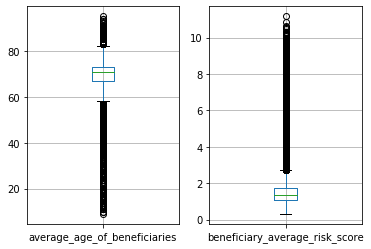

In [118]:
f, (ax1, ax2) = plt.subplots(1, 2)
us_provider.boxplot('average_age_of_beneficiaries', ax = ax1)
us_provider.boxplot('beneficiary_average_risk_score', ax = ax2)
plt.show()

In [68]:
avg_cols = ['average_age_of_beneficiaries', 'beneficiary_average_risk_score']
for col in avg_cols:
    us_provider[col] = us_provider[col].fillna(us_provider[col].median())

In [69]:
dtypes = us_provider.dtypes
dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]
column_types = dict(zip(dtypes_col, dtypes_type))
column_types = {key:'category' if value == 'object' else value for key, value in column_types.items()}

us_provider = us_provider.astype(column_types)
us_provider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162732 entries, 0 to 1162897
Data columns (total 28 columns):
npi                                 1162732 non-null int64
nppes_provider_gender               1162732 non-null category
nppes_entity_code                   1162732 non-null category
nppes_provider_zip5                 1162731 non-null float64
nppes_provider_city                 1162732 non-null category
nppes_provider_state                1162732 non-null category
specialty_description               1162732 non-null category
total_claim_count                   1162732 non-null int64
total_30_day_fill_count             1162732 non-null float64
total_drug_cost                     1162732 non-null float64
total_day_supply                    1162732 non-null int64
bene_count                          1162732 non-null float64
average_age_of_beneficiaries        1162732 non-null float64
beneficiary_age_less_65_count       1162732 non-null float64
beneficiary_age_65_74_count       

All the appropriate columns have now been filled in! To save memory space, object variables have been converted to categorical variables.

## Aggregating Data by State

Categorical variables will be aggregated by the most common value in the column. In the case that there are multiple modes, any one of the modes will be picked as the mode. 

Certain continuous variables need to be aggregated by a certain function. Variables representing the total must be aggregated using the sum function while the average variables must be aggregated by the mean function.

In [123]:
# Dataframe for continuous variables

# Dictionary of aggregate function for each continuous variable
dtypes = geo_provider.dtypes
dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]
agg_types = dict(zip(dtypes_col, dtypes_type))
agg_types = {key:'sum' for key, value in agg_types.items() if value != 'object'}

non_col = ['nppes_provider_zip5', 'Latitude', 'Longitude']
for col in non_col:
    del(agg_types[col])

agg_types['npi'] = 'count'
agg_types['average_age_of_beneficiaries'] = 'mean'
agg_types['beneficiary_average_risk_score'] = 'mean'

state_df = us_provider.groupby('nppes_provider_state', as_index = False).agg(agg_types).rename(columns = {'nppes_provider_state': 'state', 'npi': 'provider_count'})
state_df['nppes_provider_gender'] = us_provider.groupby(['nppes_provider_state'], as_index=False)['nppes_provider_gender'].agg(pd.Series.mode)['nppes_provider_gender']
state_df['specialty_description'] = us_provider.groupby(['nppes_provider_state'], as_index=False)['specialty_description'].agg(lambda x: pd.Series.mode(x)[0])['specialty_description']

In order to compare the demographic counts across states, the counts values must be converted into percentages in respect to the total beneficiaries across the respective subgroups. I will then classify each state by their most prominent category per subgroup.

In [124]:
dem_age = [s for s in state_df.columns if "beneficiary_age" in s]
dem_gen = ['beneficiary_female_count', 'beneficiary_male_count']
dem_race = [s for s in state_df.columns if "beneficiary_race" in s]
dem_dual = ['beneficiary_nondual_count', 'beneficiary_dual_count']

dem_total = [dem_age, dem_gen, dem_race, dem_dual]
for total in dem_total:
    total_ben = state_df[total].sum(axis=1)
    for column in total:
        colname = column.replace('count', 'pct')
        state_df[colname] = state_df[column]/total_ben
        
state_df['beneficiary_age'] = [x.replace('beneficiary_age_', '').replace('_count', '') for x in state_df[dem_age].idxmax(axis=1)]
state_df['beneficiary_gender'] = [x.replace('beneficiary_', '').replace('_count', '') for x in state_df[dem_gen].idxmax(axis=1)]
state_df['beneficiary_race'] = [x.replace('beneficiary_race_', '').replace('_count', '') for x in state_df[dem_race].idxmax(axis=1)]
state_df['beneficiary_dual'] = [x.replace('beneficiary_', '').replace('_count', '') for x in state_df[dem_dual].idxmax(axis=1)]

In order to compare total values across different states, the value must be on the same scale. These values will be divided by the total number of beneficiaries per state so that the values will be in terms of per beneficiary. I have chosen to put these columns in terms of per beneficiary rather than per provider since each prescription is written per beneficiary. 

In [126]:
total_std = ['total_claim_count', 'total_30_day_fill_count', 'total_drug_cost', 'total_day_supply']

for column in total_std:
    colname = column + '_per_beneficiary'
    state_df[colname] = state_df[column]/state_df.bene_count

However, to compare the bene_count value, the variable must be in terms of per provider.

In [127]:
state_df['bene_count_per_provider'] = state_df.bene_count/state_df.provider_count
state_df.head()

,state,provider_count,total_claim_count,total_30_day_fill_count,total_drug_cost,total_day_supply,bene_count,average_age_of_beneficiaries,beneficiary_age_less_65_count,beneficiary_age_65_74_count,...,beneficiary_dual_pct,beneficiary_age,beneficiary_gender,beneficiary_race,beneficiary_dual,total_claim_count_per_beneficiary,total_30_day_fill_count_per_beneficiary,total_drug_cost_per_beneficiary,total_day_supply_per_beneficiary,bene_count_per_provider
0,AA,23,1911,2026.0,6.644012e+04,31536,979.0,69.173913,327.0,206.0,...,0.497275,less_65,female,white,nondual,1.951992,2.069459,67.865291,32.212462,42.565217
1,AE,88,25768,39044.6,2.537122e+06,1009604,6037.0,69.965909,1483.0,1899.0,...,0.419840,65_74,female,white,nondual,4.268345,6.467550,420.262059,167.236044,68.602273
2,AK,2475,1237251,1823942.8,1.396017e+08,46880084,138985.0,68.071919,38842.0,48384.0,...,0.479331,65_74,female,white,nondual,8.902047,13.123307,1004.437203,337.303191,56.155556
3,AL,14426,28477231,43504154.6,2.741835e+09,1209536804,2798062.0,67.915708,736890.0,1107177.0,...,0.322166,65_74,female,white,nondual,10.177484,15.547959,979.904947,432.276627,193.959656
4,AP,57,15717,25233.6,1.143945e+06,636556,3958.0,69.842105,937.0,1358.0,...,0.331059,65_74,female,white,nondual,3.970945,6.375341,289.021069,160.827691,69.438596


### Merging with Geocoordinates per State

The following states will be removed from the dataset since they are either a military or commonwealth state, and the geojson file of the US does not have information for these states.

https://www.50states.com/abbreviations.htm

In [135]:
state_geo = pd.read_csv('us_states_geopoint.csv')
set(state_df.state) - set(state_geo.state)

{'AA', 'AE', 'AP', 'AS', 'GU', 'MP', 'VI', 'XX'}

In [137]:
final_state = pd.merge(state_df, state_geo, on = 'state')
final_state.head()

,state,provider_count,total_claim_count,total_30_day_fill_count,total_drug_cost,total_day_supply,bene_count,average_age_of_beneficiaries,beneficiary_age_less_65_count,beneficiary_age_65_74_count,...,beneficiary_race,beneficiary_dual,total_claim_count_per_beneficiary,total_30_day_fill_count_per_beneficiary,total_drug_cost_per_beneficiary,total_day_supply_per_beneficiary,bene_count_per_provider,latitude,longitude,name
0,AK,2475,1237251,1.823943e+06,1.396017e+08,46880084,138985.0,68.071919,38842.0,48384.0,...,white,nondual,8.902047,13.123307,1004.437203,337.303191,56.155556,63.588753,-154.493062,Alaska
1,AL,14426,28477231,4.350415e+07,2.741835e+09,1209536804,2798062.0,67.915708,736890.0,1107177.0,...,white,nondual,10.177484,15.547959,979.904947,432.276627,193.959656,32.318231,-86.902298,Alabama
2,AR,8995,18236354,2.468008e+07,1.406407e+09,685512629,1581302.0,67.980878,410289.0,596868.0,...,white,nondual,11.532493,15.607444,889.397789,433.511517,175.797888,35.201050,-91.831833,Arkansas
3,AZ,23073,25197728,4.254473e+07,2.743015e+09,1191881675,3513470.0,70.044771,601770.0,1345670.0,...,white,nondual,7.171750,12.109033,780.713855,339.232063,152.276254,34.048928,-111.093731,Arizona
4,CA,119867,139100291,2.278445e+08,1.568462e+10,6385621716,16136126.0,70.949544,2356787.0,5946694.0,...,white,nondual,8.620427,14.120149,972.018871,395.734498,134.616917,36.778261,-119.417932,California


## Data Visualization & Analysis (State Level)

In [6]:
# Map of United States
import json
import folium
from branca.colormap import linear

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
us_states = f'{url}/us-states.json'

### Analysis of Demographic of Providers (State Level)

In [170]:
# Create Leaflet map
from folium.plugins import MarkerCluster

m = folium.Map([43, -100], zoom_start=4)

choropleth = folium.Choropleth(
    geo_data=us_states,
    data= final_state,
    columns=['state', 'provider_count'],
    key_on='feature.id',
    fill_color='YlGn',
    name='Provider Distribution',
    legend_name='Provider Count (#)'
).add_to(m)

for each in final_state.iterrows():
    folium.Marker(location=[each[1]['latitude'], each[1]['longitude']], popup=(each[1]['name'] + ": " + str(each[1]['provider_count'])), icon=folium.Icon(icon_size = (1,1), color = 'beige')).add_to(m)

display(m)

In [169]:
# Create Leaflet map
from folium.plugins import MarkerCluster

m = folium.Map([43, -100], zoom_start=4)
x = final_state.set_index('state')['nppes_provider_gender']
colormap = {'F': 'pink', 'M': 'blue'}

folium.GeoJson(
    us_states,
    name='provider_gender',
    style_function=lambda feature: {
        'fillColor': colormap(x[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,}
).add_to(m)

display(m)

TypeError: 'dict' object is not callable

### Analysis of Demographic of Beneficiaries (State Level)

In [ ]:
# Create Leaflet map
from folium.plugins import MarkerCluster
from folium.plugins import MeasureControl

m = folium.Map([43, -100], zoom_start=4)

choropleth = folium.Choropleth(
    geo_data=us_states,
    data=std_state_df,
    columns=['state', 'average_age_of_beneficiaries'],
    key_on='feature.id',
    fill_color='RdPu',
    name='Average Age Distribution',
    legend_name='Age (Years)'
).add_to(m)

choropleth = folium.Choropleth(
    geo_data=us_states,
    data=std_state_df,
    columns=['state', 'provider_count'],
    key_on='feature.id',
    fill_color='YlGn',
    name='Provider Distribution',
    legend_name='Provider Count (#)'
).add_to(m)

choropleth = folium.Choropleth(
    geo_data=us_states,
    data=std_state_df,
    columns=['state', 'std_total_drug_cost'],
    key_on='feature.id',
    fill_color='BuPu',
    name='Drug Cost Distribution',
    legend_name='Drug Cost per Provider($)',
    show = False
).add_to(m)

    
folium.LayerControl(collapsed=False).add_to(m)

m.add_child(MeasureControl())
display(m)

## US City Latitude Longitude Dataset

To aid with geocoding the providers, I have found a dataset that has the latitude and longitude for US Cities. 

(Source: https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/)

In [172]:
us_city = pd.read_csv('us-zip-code-latitude-and-longitude.csv', sep = ';')
us_city = us_city.iloc[:,:5]
us_city.head()

,Zip,City,State,Latitude,Longitude
0,71937,Cove,AR,34.398483,-94.39398
1,72044,Edgemont,AR,35.624351,-92.16056
2,56171,Sherburn,MN,43.660847,-94.74357
3,49430,Lamont,MI,43.010337,-85.89754
4,52585,Richland,IA,41.194129,-91.98027


In [179]:
us_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43191 entries, 0 to 43190
Data columns (total 4 columns):
City         43191 non-null object
State        43191 non-null object
Latitude     43191 non-null float64
Longitude    43191 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.3+ MB


In [173]:
# Unique city and state combinations and count.
from collections import Counter
combo = zip(us_city.City, us_city.State)
count = Counter(combo)
sorted(count.items(), key=lambda x: x[1], reverse=True)[:4]

[(('Washington', 'DC'), 276),
 (('Houston', 'TX'), 182),
 (('New York', 'NY'), 166),
 (('El Paso', 'TX'), 156)]

Since there are multiple geopoints per city and state combination, I will merge the latitude and longitude coordinates via city name, state name, and zip code. I am limited to the geopoints in the us_city dataset; therefore, only providers who are in a location that is found in the us_city dataset will be included in the analysis.

In [ ]:
us_provider['nppes_provider_city'] = us_provider.nppes_provider_city.str.title()

# Due to memory error, the 2 dataframes must be merged in chunks
us_city.to_csv('us_city.csv', index_label=False)

# creating a empty dataframe to save result
df_result = pd.DataFrame(columns=(us_provider.columns.append(us_city.columns)).unique())
df_result.to_csv("geo_provider.csv",index_label=False)

# deleting one df to save memory
del(us_city)

def preprocess(x):
    df2=pd.merge(us_provider,x, how = 'inner', left_on = ["nppes_provider_city", "nppes_provider_state", "nppes_provider_zip5"], right_on = ["City", "State", "Zip"])
    df2.to_csv("geo_provider.csv",mode="a",header=False,index=False)

reader = pd.read_csv("us_city.csv", chunksize=1000) # chunksize depends with you colsize

[preprocess(r) for r in reader]

In [18]:
geo_provider = pd.read_csv('geo_provider.csv')
geo_provider = geo_provider.drop(columns = ['Zip', 'City' , 'State'])
geo_provider.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079998 entries, 0 to 1079997
Data columns (total 30 columns):
npi                                 1079998 non-null int64
nppes_provider_gender               1079995 non-null object
nppes_entity_code                   1079998 non-null object
nppes_provider_zip5                 1079998 non-null float64
nppes_provider_city                 1079998 non-null object
nppes_provider_state                1079998 non-null object
specialty_description               1079998 non-null object
total_claim_count                   1079998 non-null int64
total_30_day_fill_count             1079998 non-null float64
total_drug_cost                     1079998 non-null float64
total_day_supply                    1079998 non-null int64
bene_count                          1079998 non-null float64
average_age_of_beneficiaries        1079998 non-null float64
beneficiary_age_less_65_count       1079998 non-null float64
beneficiary_age_65_74_count         1079998 

## Aggregating  Information by Location

Certain continuous variables need to be aggregated by a certain function. Variables representing the total must be aggregated using the sum function while the average variables must be aggregated by the mean function.

In [19]:
# Dataframe for continuous variables

# Dictionary of aggregate function for each continuous variable
dtypes = geo_provider.dtypes
dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]
agg_types = dict(zip(dtypes_col, dtypes_type))
agg_types = {key:'sum' for key, value in agg_types.items() if value != 'object'}

non_col = ['nppes_provider_zip5', 'Latitude', 'Longitude']
for col in non_col:
    del(agg_types[col])

agg_types['npi'] = 'count'
agg_types['average_age_of_beneficiaries'] = 'mean'
agg_types['beneficiary_average_risk_score'] = 'mean'

# Grouping the information by location
df_con = geo_provider.groupby(['nppes_provider_zip5', 'nppes_provider_city', 'nppes_provider_state', 'Latitude', 'Longitude']
                              , as_index=False).agg(agg_types).rename(columns = {'npi': 'provider_count'})

df_con.head()

,nppes_provider_zip5,nppes_provider_city,nppes_provider_state,Latitude,Longitude,provider_count,total_claim_count,total_30_day_fill_count,total_drug_cost,total_day_supply,...,beneficiary_male_count,beneficiary_race_white_count,beneficiary_race_black_count,beneficiary_race_asian_pi_count,beneficiary_race_hispanic_count,beneficiary_race_nat_ind_count,beneficiary_race_other_count,beneficiary_nondual_count,beneficiary_dual_count,beneficiary_average_risk_score
0,601.0,Adjuntas,PR,18.180103,-66.749470,18,102186,127464.8,3908303.92,3628042,...,2135.0,55.0,15.0,10.0,1394.0,10.0,10.0,2871.0,139.0,1.472456
1,602.0,Aguada,PR,18.363285,-67.180240,76,326482,438696.9,14666929.27,12406912,...,7708.0,235.0,74.0,35.0,3921.0,40.0,40.0,11171.0,756.0,1.645311
2,603.0,Aguadilla,PR,18.448619,-67.134220,153,500997,639600.6,27682018.19,17959793,...,18773.0,440.0,155.0,85.0,11690.0,192.0,125.0,33740.0,2055.0,1.647691
3,604.0,Aguadilla,PR,18.498987,-67.136990,11,31262,44543.1,964159.30,1276166,...,1379.0,35.0,15.0,10.0,588.0,10.0,20.0,2334.0,113.0,1.641091
4,605.0,Aguadilla,PR,18.465162,-67.141486,19,40581,47608.5,2178593.91,1357835,...,1329.0,65.0,30.0,25.0,858.0,25.0,30.0,1387.0,125.0,1.689500


In [ ]:
# Attempting to put marker per latitude longitude coordinate but not working

marker_cluster = MarkerCluster(name = 'Provider').add_to(m)

for each in df_con.iterrows():
    folium.Marker(
        location=[each[1]['Latitude'], each[1]['Longitude']],
    popup=each[1]['provider_count'],
    icon=None,
).add_to(marker_cluster)